# Validation metrics and plots

In [1]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import poligrain as plg

## Preparing the data sets

So far this notebook only covers the comparison between CML and radar. <br>
*Note: the functions should in principle be able to handle validation with another (point based) sensor too, provided that the data has been correctly coupled to the CML data before hand.*

### Load CML and radar data
Following the example from [`Get_grid_at_lines_and_points.ipynb`](https://github.com/OpenSenseAction/poligrain/blob/main/docs/notebooks/Get_grid_at_lines_and_points.ipynb), we use CML data that has already been processed to include path-averaged rainfall rate (see how that is done [here](https://github.com/OpenSenseAction/merging_prototype/blob/9cd018be263a8f5ae38bb28c1f768b353d97ffbc/radar_cml_gauge_merge_prototype.ipynb)).  

In [2]:
# Load datasets
ds_cmls = xr.open_dataset("data/openMRG_cmls_20150827_12hours.nc")
ds_radar = xr.open_dataset("data/openMRG_example_rad_20150827_90minutes.nc")

### Resample CML data

*Note: the validation functions used in this notebook often take two arrays as input, one for the reference (radar) and one for the estimates (CMLs). The functions do not ensure that the temporal resolution matches, nor that the temporal alignment between the radar and CMLs is correct.* 
***It is the users responsibility to do this before the data is used in the functions.*** 
*Below we show an example of how to do this for the sample data used in this notebook.* <br>

The radar data is in 5 minute intervals, and the CML data in 1 minute intervals, so we resample the CML data to 5 minutes. <br>
Both CML and radar rainfall rate are already in mm/hr, so need to do any transformation here. 

In [3]:
ds_cmls_5m = ds_cmls.R.resample(time="5min", label="right").mean()

### Get one radar value for each CML value
We want to compare the radar estimates along the line with the CML based rainfall estimates on a point to point basis. We therefore need to make sure that we use the same time period. 



In [4]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar,
    ds_line_data=ds_cmls_5m,
    # we did not reproject the coordinates in this notebook, hence we use lon-lat
    # which gives distoted lengths calculations, but is okay in this example.
    use_lon_lat=True,
)

In [5]:
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_radar.rainfall)

ds_cmls_5m = ds_cmls_5m.where(ds_cmls_5m.time.isin(radar_along_cml.time), drop=True)

Then we need to make sure that for each sub-link, there is a radar rainfall estimate to compare to. For simplicity we just take the first of the two sub-links (i.e. sub-link 0). Note that there should not be much difference between the two sub-links since they cover the same path, but at slighlty different frequencies. 

Finally, for this data set each sublink item has shape cml_id\*time (364\*19) whereas the radar\_along\_cml data has shape (19\*364), so we transpose the radar data.

In [6]:
sublink_0 = ds_cmls_5m.isel(sublink_id=0)

cmls_flattened = sublink_0.to_numpy().flatten()

radar_flattened = radar_along_cml.to_numpy().T.flatten()

If we want to use both sub-links in the dataset at the same time to compare to the radar data we can do that as follows: 

In [7]:
sublink_0 = ds_cmls_5m.isel(sublink_id=0)
sublink_1 = ds_cmls_5m.isel(sublink_id=1)

cmls_flattened_duo = np.concatenate(
    [sublink_0.to_numpy().flatten(), sublink_1.to_numpy().flatten()]
)

radar_flattened_duo = np.tile(radar_along_cml.to_numpy().T.flatten(), 2)

## Visualize the validation

First we set a threshold. Any value below this is not plotted. This can be the same or different for the reference and estimated rainfall intensities.  


In [8]:
threshold = 0.1  # mm/h

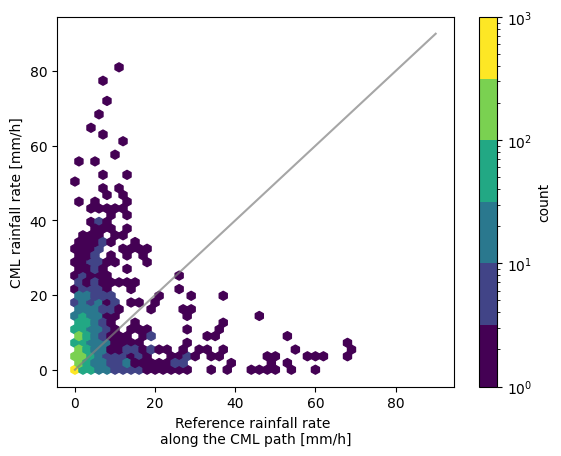

In [9]:
fig, ax = plt.subplots()
hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    ax=ax,
)

By plotting two scatter plots with different thresholds next to each other we can nicely see the effect the threshold has. 

Text(0.5, 1.0, 'Threshold = 5 mm/h')

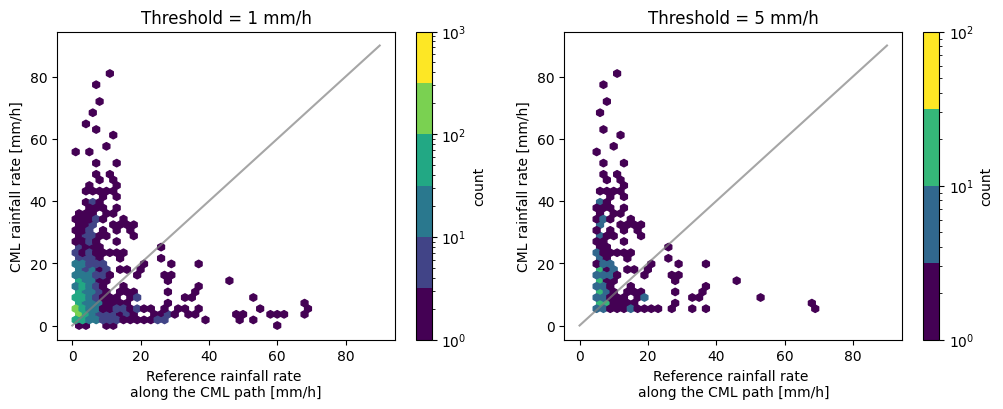

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened,
    ref_thresh=1,
    est_thresh=1,
    ax=ax[0],
)
ax[0].set_title("Threshold = 1 mm/h")

hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened,
    ref_thresh=5,
    est_thresh=5,
    ax=ax[1],
)
ax[1].set_title("Threshold = 5 mm/h")

We can also adapt the layout of the plot, such as the colorscheme and the labels. 

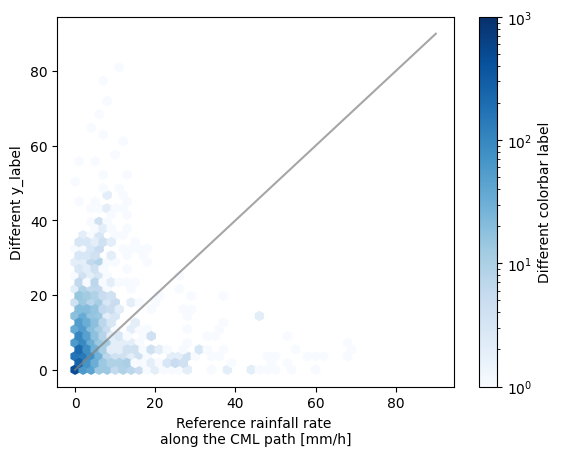

In [11]:
fig, ax = plt.subplots()
hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    ax=ax,
)

ax.set_ylabel("Different y_label")

# change colormap and label
hx.set_cmap("Blues")
hx.colorbar.set_label("Different colorbar label")

## Calculate validation metrics


The following functions calculate some rainfall metrics. By setting the thresholds we can ensure we get the metrics corresponding to the data plotted in the scatter density plots above. 

Note that the units in the outputted rainfall metrics dictionary will depend on the units of the input array! <br> Most probably mm/h or mm.

In [12]:
threshold = 0.1

rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
)

rainfall_metrics

{'ref_thresh': 0.1,
 'est_thresh': 0.1,
 'pearson_correlation_coefficient': np.float64(0.18801729902100803),
 'coefficient_of_variation': np.float64(3.3112926123357327),
 'root_mean_square_error': np.float64(8.557064854089502),
 'mean_absolute_error': np.float64(4.33235119817323),
 'percent_bias': np.float64(68.03124873073267),
 'reference_mean_rainfall': np.float64(2.5313343675729216),
 'estimate_mean_rainfall': np.float64(4.253432747382974),
 'false_positive_mean_rainfall': np.float64(1.5879088729016786),
 'false_negative_mean_rainfall': np.float64(1.3919088136037072),
 'N_all': 6916,
 'N_nan': np.int64(190),
 'N_nan_ref': np.int64(0),
 'N_nan_est': np.int64(190)}

Just as in the calculation of the rainfall metrics the wet-dry metrics will depend on the threshold given. The default is zero. 

In [13]:
wet_dry_metrics = plg.validation.calculate_wet_dry_metrics(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
)

wet_dry_metrics

{'matthews_correlation_coefficient': np.float64(0.4052033743232488),
 'true_positive_ratio': np.float64(0.6388291003013344),
 'true_negative_ratio': np.float64(0.7995192307692308),
 'false_positive_ratio': np.float64(0.20048076923076924),
 'false_negative_ratio': np.float64(0.3611708996986655),
 'N_dry_ref': np.int64(2080),
 'N_wet_ref': np.int64(4646),
 'N_tp': np.int64(2968),
 'N_tn': np.int64(1663),
 'N_fp': np.int64(417),
 'N_fn': np.int64(1678),
 'N_all': 6916,
 'N_nan': np.int64(190),
 'N_nan_ref': np.int64(0),
 'N_nan_est': np.int64(190)}

Now, combining all the functions we have used so far, we can for example compare the difference in metrics between the two sublinks, and add these to the scatter density plots. 

Text(0.95, 0.55, 'pearson r: 0.18\nrmse: 8.44 mm/h\nbias: 65.57%\nN points: 6916\nN nans: 190')

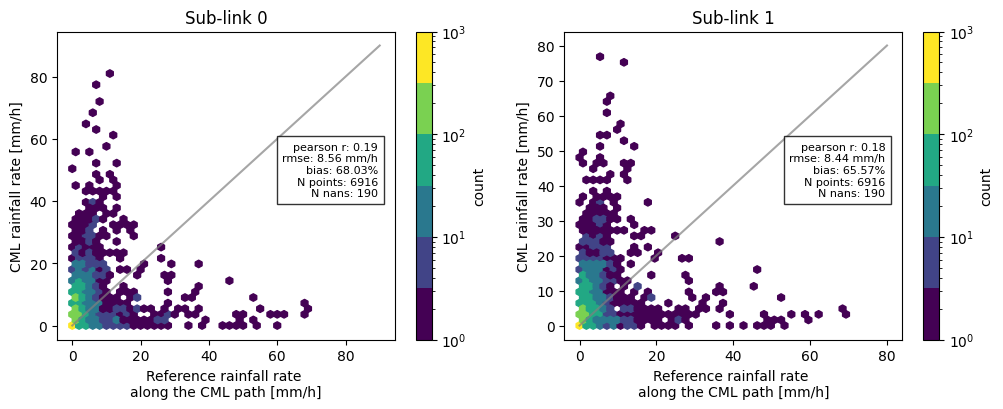

In [14]:
threshold = 0.1

sublink_1 = ds_cmls_5m.isel(sublink_id=1)
cmls_flattened_1 = sublink_1.to_numpy().flatten()

rainfall_metrics = plg.validation.calculate_rainfall_metrics(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
)

rainfall_metrics_1 = plg.validation.calculate_rainfall_metrics(
    reference=radar_flattened,  # we still compare to the same reference
    estimate=cmls_flattened_1,
    ref_thresh=threshold,
    est_thresh=threshold,
)

# plotting the scatter density plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    ax=ax[0],
)
ax[0].set_title("Sub-link 0")

hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened_1,
    ref_thresh=threshold,
    est_thresh=threshold,
    ax=ax[1],
)
ax[1].set_title("Sub-link 1")

# adding metrics to the plot for subplot 0
plotted_metrics = (
    f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
    f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
    f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
    f"N points: {rainfall_metrics['N_all']}\n"
    f"N nans: {rainfall_metrics['N_nan']}"
)

ax[0].text(
    0.95,
    0.55,
    plotted_metrics,
    fontsize=8,
    transform=ax[0].transAxes,
    verticalalignment="center",
    horizontalalignment="right",
    bbox={"facecolor": "white", "alpha": 0.8},
)

# adding metrics to the plot for subplot 1
plotted_metrics_1 = (
    f"pearson r: {np.round(rainfall_metrics_1['pearson_correlation_coefficient'], 2)}\n"
    f"rmse: {np.round(rainfall_metrics_1['root_mean_square_error'], 2)} mm/h\n"
    f"bias: {np.round(rainfall_metrics_1['percent_bias'], 2)}%\n"
    f"N points: {rainfall_metrics_1['N_all']}\n"
    f"N nans: {rainfall_metrics_1['N_nan']}"
)

ax[1].text(
    0.95,
    0.55,
    plotted_metrics_1,
    fontsize=8,
    transform=ax[1].transAxes,
    verticalalignment="center",
    horizontalalignment="right",
    bbox={"facecolor": "white", "alpha": 0.8},
)

### Print pretty table with verification metrics
Simply printing the metrics like above looks a little bit messy, so we can call the function ```print_metrics_table``` that prints each of the items from the metrics dictionaries into a prettier table. 


In [15]:
plg.validation.print_metrics_table(rainfall_metrics)

'Verification metrics:\n\n+=================================+===============+==========+\n|              Metric             |     Value     |   Units  |\n+=================================+===============+==========+\n| Reference rainfall threshold    |      0.1      |   [mm/h] |\n+---------------------------------+---------------+----------+\n| Estimate rainfall threshold     |      0.1      |   [mm/h] |\n+---------------------------------+---------------+----------+\n| Pearson correlation coefficient |     0.188     |    [-]   |\n+---------------------------------+---------------+----------+\n| Coefficient of variation        |     3.311     |    [-]   |\n+---------------------------------+---------------+----------+\n| Root mean square error          |     8.557     |   [mm/h] |\n+---------------------------------+---------------+----------+\n| Mean absolute error             |     4.332     |   [mm/h] |\n+---------------------------------+---------------+----------+\n| Percent bias

Or alternatively, if we only want to print a subset of the rainfall metrics: 

In [16]:
metrics_subset = {
    k: v
    for k, v in rainfall_metrics.items()
    if k
    in [
        "ref_thresh",
        "est_thresh",
        "pearson_correlation_coefficient",
        "coefficient_of_variation",
        "root_mean_square_error",
        "mean_absolute_error",
        "percent_bias",
        "reference_mean_rainfall",
        "estimate_mean_rainfall",
    ]
}

plg.validation.print_metrics_table(metrics_subset)

'Verification metrics:\n\n+=================================+===============+==========+\n|              Metric             |     Value     |   Units  |\n+=================================+===============+==========+\n| Reference rainfall threshold    |      0.1      |   [mm/h] |\n+---------------------------------+---------------+----------+\n| Estimate rainfall threshold     |      0.1      |   [mm/h] |\n+---------------------------------+---------------+----------+\n| Pearson correlation coefficient |     0.188     |    [-]   |\n+---------------------------------+---------------+----------+\n| Coefficient of variation        |     3.311     |    [-]   |\n+---------------------------------+---------------+----------+\n| Root mean square error          |     8.557     |   [mm/h] |\n+---------------------------------+---------------+----------+\n| Mean absolute error             |     4.332     |   [mm/h] |\n+---------------------------------+---------------+----------+\n| Percent bias

## Visualize the contribution of the different parts of the confusion matrix (TP, FP, FN)
We essentially plot 3 parts of the confusion matrix, the true positives, false positives, and false negatives, corresponding to the scatter density plots from before. 

In [17]:
# set the threshold
threshold = 0.1  # mm/h

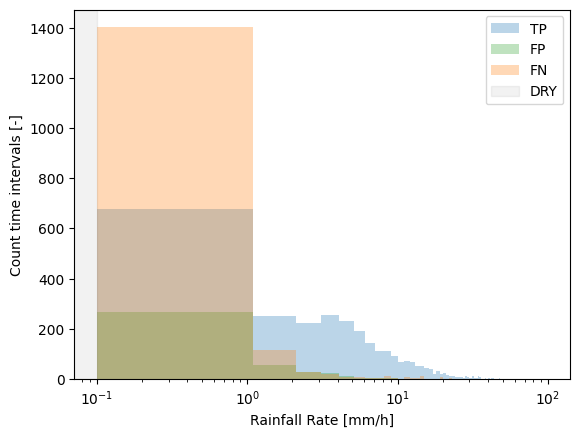

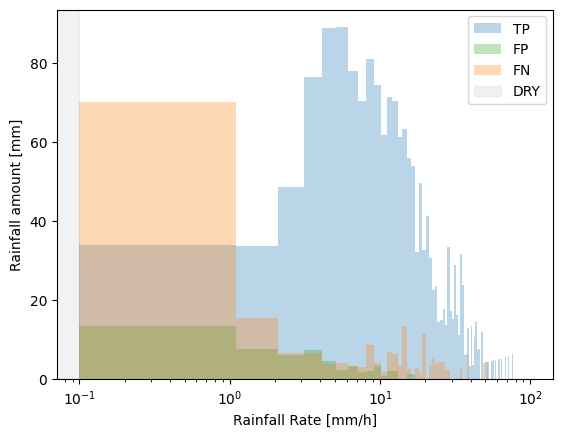

In [18]:
steps = plg.validation.plot_confusion_matrix_count(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    normalize_y=1,
    n_bins=101,
    bin_type="linear",
)


# to calculate the sum we must add the time interval in minutes as an argument
_ = plg.validation.plot_confusion_matrix_sum(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    time_interval=5,  # minutes
)

The default ```bin_type='linear'```. Intuitively this should be more easy to understand as all of the bins have equal width. However, most of the rain falls in the lower bins, with only a few intervals that fall within the higher intensity bins. Accomdating this wide range of rainfall intensities on the x-axis would make the lower bins not very well visible. Therefore, the x-axis is log-scaled by default. 

This, however, comes with the downside that when plotting linear bins on a log scale, the lower bins are relatively large. 

We can deal with this by setting ```bins='log'```, but be aware that though this may be more visually appealing, it may be more difficult to intuitively understand the distribution of the underlying data, as the bin edges are now not equally spaced anymore. 

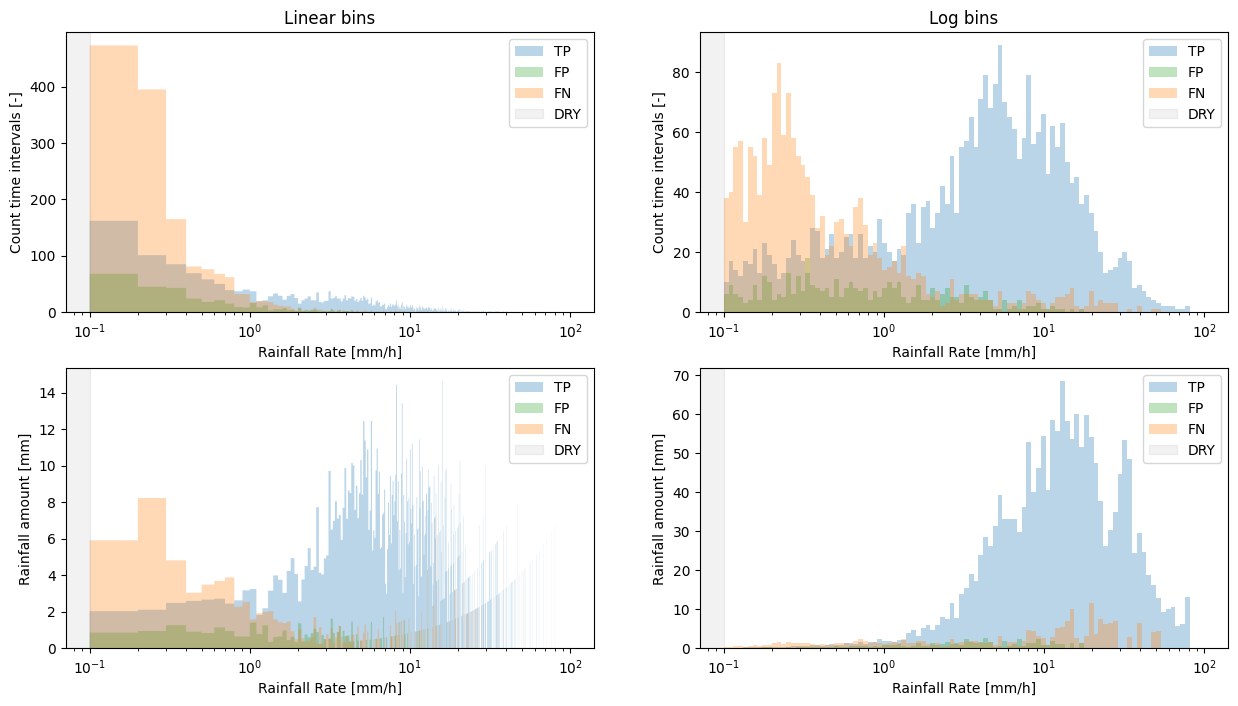

In [19]:
# Example of linear vs. log bins
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

steps_l = plg.validation.plot_confusion_matrix_count(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    bin_type="linear",
    n_bins=1000,  # increase nr. of bins to make bins smaller
    ax=ax[0, 0],
)
ax[0, 0].set_title("Linear bins")

steps_l = plg.validation.plot_confusion_matrix_count(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    bin_type="log",
    ax=ax[0, 1],
)
ax[0, 1].set_title("Log bins")

_ = plg.validation.plot_confusion_matrix_sum(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    bin_type="linear",
    time_interval=5,  # minutes
    n_bins=1000,  # increase nr. of bins to make bins smaller
    ax=ax[1, 0],
)

_ = plg.validation.plot_confusion_matrix_sum(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    bin_type="log",
    time_interval=5,  # minutes
    ax=ax[1, 1],
)

We can also specify whether to show the plots as totals for the entire data set, or as an average per sub-link, by normalizing the y-axis

In [20]:
# since we only use the first sublink, this is the same as the number of CMLs
number_of_links = ds_cmls_5m.sizes.get("cml_id")

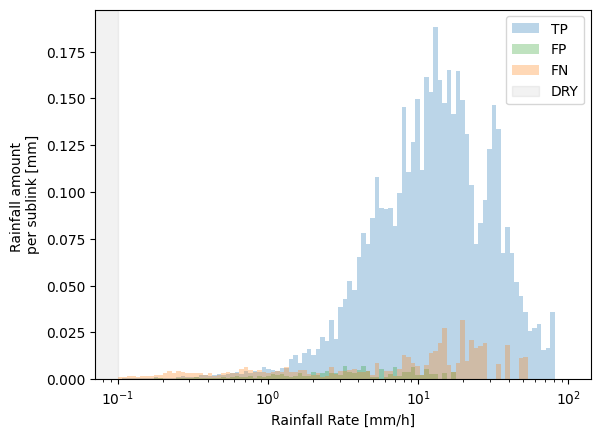

In [21]:
plg.validation.plot_confusion_matrix_sum(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    normalize_y=number_of_links,
    time_interval=5,  # minutes
    bin_type="log",
)

Finally, we can adapt all these plots and add them together in one figure as subplots, for example.

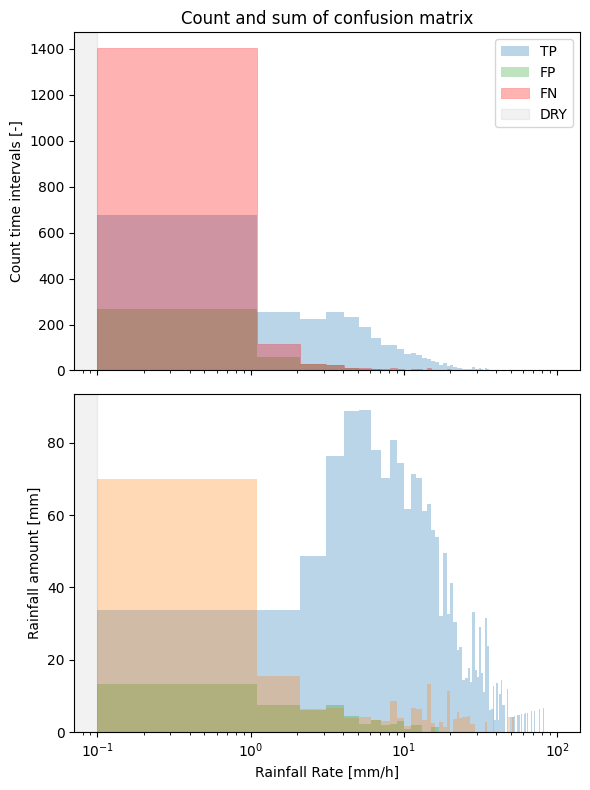

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

steps_count = plg.validation.plot_confusion_matrix_count(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    normalize_y=1,
    ax=ax[0],
)

steps_sum = plg.validation.plot_confusion_matrix_sum(
    reference=radar_flattened,
    estimate=cmls_flattened,
    ref_thresh=threshold,
    est_thresh=threshold,
    time_interval=5,
    ax=ax[1],
)

# change the colors
steps_count[2].set_color("red")

# call the first legend to update the colors, and remove legend in the second subplot
ax[0].legend()
ax[1].legend().set_visible(False)

# remove xlabel in the first subplot since we share the x-axis
ax[0].set(xlabel=None)

# add a title
ax[0].set_title("Count and sum of confusion matrix")

fig.tight_layout()